#### Input Analysis

In [8]:
import pandas as pd

data = pd.read_csv("./input_data/   .csv")
print(data.shape)
data.dropna(subset=['ID', 'LINKEDIN_URL_PERSON'], inplace=True)
print(data.shape)
print(data['LINKEDIN_URL_PERSON'].nunique())

(146817, 2)
(146817, 2)
146817


#### Cosine Similarity Results Generation

In [3]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
tqdm.pandas()

def match_urls(list1, list2, threshold=0.90):
    # Load pre-trained BERT model
    model = SentenceTransformer('distilbert-base-nli-mean-tokens')
    
    # Generate embeddings for both lists
    embeddings1 = model.encode(list1, show_progress_bar=True)
    embeddings2 = model.encode(list2, show_progress_bar=True)
    
    # Initialize results list
    matches = []
    
    # Calculate cosine similarity and find matches
    for i, emb1 in enumerate(tqdm(embeddings1, desc="Matching URLs")):
        similarities = cosine_similarity([emb1], embeddings2)[0]
        best_match_index = np.argmax(similarities)
        best_match_score = similarities[best_match_index]
        
        if best_match_score >= threshold:
            matches.append((list1[i], list2[best_match_index], best_match_score))
    
    return matches

In [1]:
import pandas as pd

crm_df = pd.read_csv("./input_data/VW_SF_CRM_MATCH.csv")
crm_df.dropna(subset=['ID', 'COMPANY_WEBSITE'], inplace=True)
crm_df.rename(columns={'ID': 'CRM_ID'}, inplace=True)
crm_df = crm_df.sample(frac=0.2)
print("crm_df:", crm_df.shape)

ss_df = pd.read_csv('./input_data/VW_SS_COMPANY_MATCH.csv')
ss_df.dropna(subset=['ID', 'WEBSITE'], inplace=True)
ss_df = ss_df.sample(frac=0.2)
print("ss_df:", ss_df.shape)

crm_df: (5409, 4)
ss_df: (626269, 2)


In [4]:
# Example usage
urls1 = crm_df['COMPANY_WEBSITE'].to_list()
urls2 = ss_df['WEBSITE'].to_list()

# urls1_smaple = urls1[:20000]
# urls2_smaple = urls2[:20000]

results = match_urls(urls1, urls2)
# results = match_urls(urls1_smaple, urls2_smaple)

result_df = pd.DataFrame()
result_df[['CRM_URL', 'SS_URL', "Similarity_Score"]] = results

result_df.head()

# print("Matched URLs:")
# for url1, url2, score in results:
#     print(f"{url1} <-> {url2} (Similarity: {score:.2f})")

Batches:   0%|          | 0/170 [00:00<?, ?it/s]

Batches:   0%|          | 0/19571 [00:00<?, ?it/s]

Matching URLs:   0%|          | 0/5409 [00:00<?, ?it/s]

,CRM_URL,SS_URL,Similarity_Score
0,https://boo.world/,https://boo.vn,0.903644
1,www.mobot.io,https://www.mobot.io,0.951254
2,zengistics.com,http://zenogroupinvestments.com,0.925164
3,www.joinair.com,https://joinair.com,0.970445
4,www.pixformance.com,https://www.pixgrammer.com,0.956128


In [5]:
result_df.to_csv("crm_ss_cosine_match_20p.csv")

 #### Cosine Simialrity Results Comparison

In [4]:
import pandas as pd
from tqdm.notebook import tqdm
from preprocessor import URLPreprocessor
tqdm.pandas()

preprocess = URLPreprocessor()

result_df = pd.read_csv("crm_cb_cosine_match.csv")

result_df['crm_company'] = result_df['CRM_URL'].progress_apply(preprocess.extract_domain_and_company)
result_df['cb_company'] = result_df['CB_URL'].progress_apply(preprocess.extract_domain_and_company)

  0%|          | 0/853974 [00:00<?, ?it/s]

  0%|          | 0/853974 [00:00<?, ?it/s]

In [5]:
result_df['match'] = result_df.progress_apply(lambda x: 1 if x['crm_company'] == x['cb_company'] else 0, axis=1)

  0%|          | 0/853974 [00:00<?, ?it/s]

In [6]:
result_df.head()

,CRM_URL,CB_URL,Similarity_Score,crm_company,cb_company,match
0,https://www.bits.bi/,https://www.bits.bi/,1.0,bits.bi,bits.bi,1
1,https://greatquestion.co/,https://greatquestion.co/,1.0,greatquestion.co,greatquestion.co,1
2,https://octopus.energy/,https://octopus.energy/,1.0,octopus.energy,octopus.energy,1
3,https://charac.co.uk/,https://charac.co.uk/,1.0,charac.co.uk,charac.co.uk,1
4,https://payfina.com/,https://payfina.com/,1.0,payfina.com,payfina.com,1


In [8]:
# Group by 'CRM_URL' and get the index of the row with the maximum 'Similarity_Score' for each group
idx = result_df.groupby('CRM_URL')['Similarity_Score'].idxmax()

# Use loc to filter the DataFrame based on these indices
result_df = result_df.loc[idx]

# If you want to reset the index after this operation
result_df = result_df.reset_index(drop=True)
print(result_df.shape)
print(result_df['CRM_URL'].nunique())
result_df.head()

(4624, 6)
4624


,CRM_URL,CB_URL,Similarity_Score,crm_company,cb_company,match
0,1build.com,http://1byone.com,0.9274,1build.com,1byone.com,0
1,1mg.com,http://1seo.com,0.9223,1mg.com,1seo.com,0
2,1plusx.com,http://1plusx.com,0.9373,1plusx.com,1plusx.com,1
3,1qbit.com,https://1qbit.com,0.9230,1qbit.com,1qbit.com,1
4,1stdibs.com,https://1stDigital.com,0.9305,1stdibs.com,1stdigital.com,0


In [9]:
result_df['match'].value_counts()

match
1    2956
0    1668
Name: count, dtype: int64

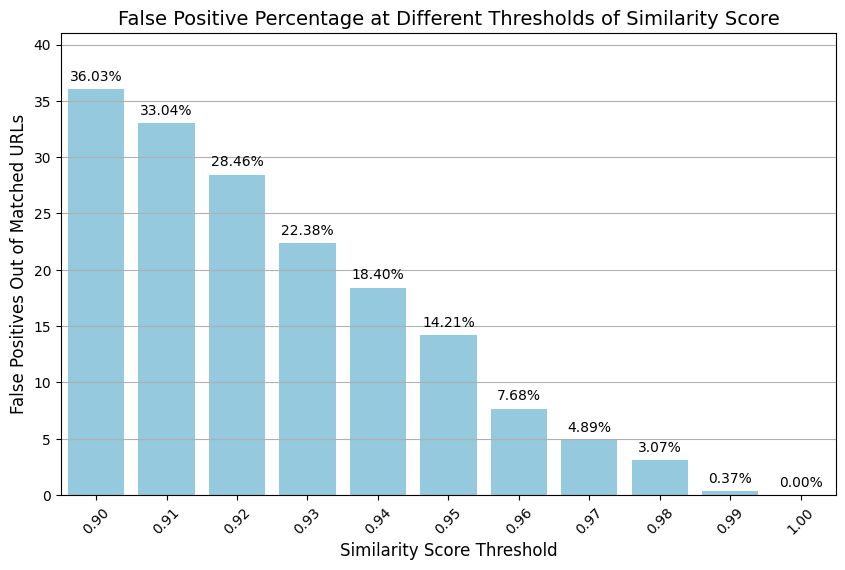

In [14]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define the thresholds for Similarity Score
thresholds = np.arange(0.90, 1.01, 0.01)

# Calculate the count of zeros in the match column for each threshold
zero_counts = []
for threshold in thresholds:
    count_zeros = result_df[(result_df['Similarity_Score'] > threshold) & (result_df['match'] == 0)].shape[0]
    zero_counts.append(count_zeros)

# Calculate the False Positive Percentage at each threshold
false_positive_percent = [(count_zeros / 4624) * 100 for count_zeros in zero_counts]

# Create a bar plot using seaborn with all thresholds visible on x-axis
plt.figure(figsize=(10, 6))
sns.barplot(x=thresholds, y=false_positive_percent, color='skyblue')

# Add labels to each bar with the actual percentage
for i, v in enumerate(false_positive_percent):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom', fontsize=10)

plt.title('False Positive Percentage at Different Thresholds of Similarity Score', fontsize=14)
plt.xlabel('Similarity Score Threshold', fontsize=12)
plt.ylabel('False Positives Out of Matched URLs', fontsize=12)
plt.ylim(0, max(false_positive_percent) + 5)
plt.xticks(ticks=range(len(thresholds)), labels=[f'{th:.2f}' for th in thresholds], rotation=45)
plt.grid(axis='y')
plt.show()

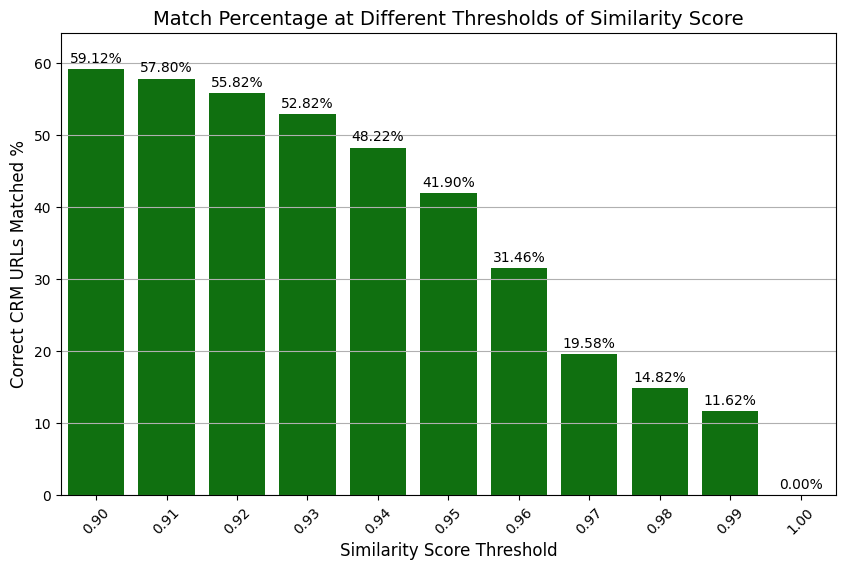

In [15]:
# Calculate the Match Percentage at each threshold
match_counts = []
for threshold in thresholds:
    count_ones = result_df[(result_df['Similarity_Score'] > threshold) & (result_df['match'] == 1)].shape[0]
    match_counts.append(count_ones)

match_percent = [(count_ones / 5000) * 100 for count_ones in match_counts]

# Create a bar plot using seaborn for Match Percentage
plt.figure(figsize=(10, 6))
sns.barplot(x=thresholds, y=match_percent, color='green')

# Add labels to each bar with the actual percentage
for i, v in enumerate(match_percent):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom', fontsize=10)

plt.title('Match Percentage at Different Thresholds of Similarity Score', fontsize=14)
plt.xlabel('Similarity Score Threshold', fontsize=12)
plt.ylabel('Correct CRM URLs Matched %', fontsize=12)
plt.ylim(0, max(match_percent) + 5)
plt.xticks(ticks=range(len(thresholds)), labels=[f'{th:.2f}' for th in thresholds], rotation=45)
plt.grid(axis='y')

plt.show()

#### Duplicacy Handling

In [1]:
import pandas as pd

data = pd.read_csv("./match_tables/crm_cb_matched.csv")

duplicate_companies = data.groupby('cb_company').filter(lambda x: len(x) > 1)
duplicate_companies

,CRM_ID,UUID,COMPANY_WEBSITE,HOMEPAGE_URL,crm_company,cb_company
42,001i000001utkTJAAY,d7c6c9d9-8468-c284-dc83-5f384cfa39b9,architizer.com,http://www.architizer.com,architizer.com,architizer.com
43,001i000001utkTJAAY,0ec2f31b-a156-487f-8494-84e61fc71651,architizer.com,https://architizer.com/firms/grassicorrea-arch...,architizer.com,architizer.com
54,0011Y00002PgFNnQAN,a8ed1c98-a124-ae72-514a-5bbc66fe66bb,tellius.com,http://www.tellius.com,tellius.com,tellius.com
55,0011Y00002PgFNnQAN,c9386261-6653-4c3d-bfa7-f4391c850960,tellius.com,http://www.tellius.com,tellius.com,tellius.com
88,001i000001PLvwYAAT,4ebf3e17-b049-776e-01c4-f103f61478cc,wattpad.com,https://www.wattpad.com,wattpad.com,wattpad.com
...,...,...,...,...,...,...
27857,0011Y00003ASsFqQAL,2ff6de55-18e4-49c5-a328-ae7604d677f6,www.clementineapp.com,https://clementineapp.com/,clementineapp.com,clementineapp.com
27858,0011Y00003ASsFqQAL,622b6b11-9973-ce68-51c8-7e2552413762,www.clementineapp.com,https://clementineapp.com/,clementineapp.com,clementineapp.com
27915,001i000001ISCRsAAP,ca84254b-ab53-ee8a-6630-e0c32d0be45e,welltok.com,http://welltok.com,welltok.com,welltok.com
27916,001i000001ISCRsAAP,3b9a855a-41ba-464c-99c1-28548930c87a,welltok.com,https://www.welltok.com/,welltok.com,welltok.com


In [2]:
from postprocess import process_all_matched_outputs

match_tables = [{'matched_path': "./match_tables/crm_cb_matched.csv"}]

process_all_matched_outputs = process_all_matched_outputs(match_tables)

In [3]:
crm_df = pd.read_csv("./match_tables/crm_cb_matched.csv")
duplicate_companies = crm_df.groupby('cb_company').filter(lambda x: len(x) > 1)

In [4]:
duplicate_companies

,CRM_ID,UUID,COMPANY_WEBSITE,HOMEPAGE_URL,crm_company,cb_company


In [6]:
data1 = pd.read_csv("./input_data/VW_SF_CRM_MATCH.csv")
print(data1.shape)
data2 = pd.read_csv("./input_data/VW_SF_CRM_MATCH_NEW.csv")
print(data2.shape)

(27052, 4)
(27079, 4)


In [7]:
data1 = pd.read_csv("./input_data/VW_SF_CRM_MATCH.csv")
data1.dropna(subset=['ID', 'COMPANY_WEBSITE'], inplace=True)
data1.rename(columns={'ID': 'CRM_ID'}, inplace=True)

subdata = pd.read_csv("./unmatch_tables/crm_bd_comp_unmatched.csv")
output = data1[data1['CRM_ID'].isin(subdata['CRM_ID'].tolist())][['CRM_ID', 'COMPANY_WEBSITE']]

output.to_csv("./unmatch_tables/crm_bd_comp_unmatched.csv")

In [8]:
output.to_csv("./unmatch_tables/crm_bd_comp_unmatched.csv", index=False)

#### Unit Testing

In [9]:
import pandas as pd
import numpy as np
import os
from matcher import Matcher

def create_test_dataframes():
    # Test data for the first DataFrame (e.g., CRM data)
    df1_data = {
        'ID': ['CRM001', 'CRM002', 'CRM003', None, np.nan],
        'COMPANY_WEBSITE': [
            'https://www.example.com',
            'http://test-company.co.uk',
            'www.linkedin.com/company/acme-corp',
            np.nan,
            None, 
        ]
    }
    
    # # Test data for the second DataFrame (e.g., external data source)
    # df2_data = {
    #     'UUID': ['EXT001', 'EXT002', 'nan', np.nan, None],
    #     'HOMEPAGE_URL': [
    #         'http://example.com',
    #         12.456,
    #         'https://acme-corp.com',
    #         'http://インターナショナル-テスト.jp',
    #         1234
    #     ]
    # }

    # df2_data = {"UUID": [], "HOMEPAGE_URL": []}
    df2_data = None
    
    df1 = pd.DataFrame(df1_data)
    df2 = pd.DataFrame(df2_data)
    
    return df1, df2

def run_unit_tests():
    # Create an instance of the Matcher class
    matcher = Matcher(log_file='unit_test.log')
    
    # Create test DataFrames
    df1, df2 = create_test_dataframes()
    
    # Save test DataFrames to CSV files
    df1.to_csv('test_df1.csv', index=False)
    df2.to_csv('test_df2.csv', index=False)
    
    # Run the process function
    matcher.process(
        file_path1='test_df1.csv',
        file_path2='test_df2.csv',
        id_col1='ID',
        id_col2='UUID',
        url_col1='COMPANY_WEBSITE',
        url_col2='HOMEPAGE_URL',
        company_col1='crm_company',
        company_col2='ext_company',
        matched_path="test_matched.csv",
        unmatched_path="test_unmatched.csv",
        rename_dict1=None,
        rename_dict2=None
    )
    
    # # Load and print the results
    # matched_results = pd.read_csv('test_matched.csv')
    # unmatched_results = pd.read_csv('test_unmatched.csv')
    
    # print("Matched Results:")
    # print(matched_results)
    # print("\nUnmatched Results:")
    # print(unmatched_results)
    
    # # Clean up test files
    # os.remove('test_df1.csv')
    # os.remove('test_df2.csv')
    # os.remove('test_matched.csv')
    # os.remove('test_unmatched.csv')
    # os.remove('unit_test.log')

if __name__ == "__main__":
    run_unit_tests()

Error in load_clean_and_rename_dataframe: No columns to parse from file
Error in process: One or both input DataFrames could not be loaded or processed


In [ ]:
import snowflake.connector

# Define your connection parameters
conn_params = {
    'account': 'your_account_identifier',
    'user': 'your_username',
    'password': 'your_password',
    'role': 'your_role',
    'warehouse': 'your_warehouse',
    'database': 'your_database',
    'schema': 'your_schema'
}

# Establish the connection
conn = snowflake.connector.connect(**conn_params)

# Create a cursor object
cur = conn.cursor()

# Execute a query
cur.execute("SELECT CURRENT_VERSION()")

# Fetch the result
result = cur.fetchone()
print(result)

# Close the cursor and connection
cur.close()
conn.close()


In [1]:
import pandas as pd
data1 = pd.read_csv("./input_data/VW_BD_PEOPLE_MATCH.csv")
data1.dropna(subset=['ID', 'LINKEDIN_URL_PERSON'], inplace=True)
print(data1['LINKEDIN_URL_PERSON'].nunique())

data2 = pd.read_csv('./match_tables/crm_bd_people_matched.csv')
print(data2['LINKEDIN_URL_PERSON_BD'].nunique())

146817
5001


In [2]:
print(data2['LINKEDIN_URL_PERSON'].nunique())

5001


In [5]:
data2 = pd.read_csv('./match_tables/crm_bd_people_duplicate_matched.csv')
print(data2['LINKEDIN_URL_PERSON_BD'].nunique())

1042
